In [43]:
import networkx as nx
import seaborn
import custom_funcs as cf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from joblib import Parallel, delayed
from time import time

%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
# Set Seaborn styles & context
seaborn.set_context("paper")
seaborn.set_style('white')

In [46]:
# Read in data and do data pre-processing
G = nx.read_gpickle('20150902_all_ird Final Graph.pkl')
G = cf.impute_reassortant_status(G)
G = cf.impute_host_group_name(G)
G = cf.impute_weights(G)
G = cf.remove_zero_weighted_edges(G)

In [47]:
# Compute proportion reassortant
data_props = cf.edge_proportion_reassortant(G, attr='host_group', exclusions=['Unknown'])
data_props

{'diff_attr': 0.8131267590611879, 'same_attr': 0.37525262774838164}

In [48]:
start = time()
def null_distribution_proportion_reassortant(G):
    G_shuffled = cf.shuffle_node_attribute_label(G, 'host_group')
    props = cf.edge_proportion_reassortant(G_shuffled, 'host_group', exclusions=['Unknown'])
    return props

props_null = Parallel(n_jobs=-1)(delayed(null_distribution_proportion_reassortant)(G) for i in range(100))
end = time()
print(end - start)

253.26817750930786


In [49]:
null = pd.DataFrame(props_null)
null.mean()

diff_attr    0.436598
same_attr    0.438059
dtype: float64

In [50]:
data = pd.DataFrame([data_props])
data.mean()

diff_attr    0.813127
same_attr    0.375253
dtype: float64

(0, 1)

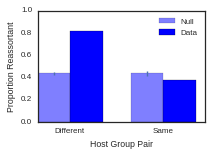

In [51]:
fig = plt.figure(figsize=(3,2))
ax = fig.add_subplot(1,1,1)
ind = np.arange(2)
width = 0.35

ax.bar(ind, null.mean(), width, color='blue', label='Null', alpha=0.5, yerr=null.std()*5)
ax.bar(ind+width, data.mean(), width, color='blue', label='Data')
ax.set_xticks(ind+width)
ax.set_xticklabels(['Different', 'Same'])
ax.set_xlabel('Host Group Pair')
ax.set_ylabel('Proportion Reassortant')
ax.legend()
ax.set_ylim(0,1)

In [52]:
# Between which host groups are they over-represented or under-represented?

def host_group_domain_graph(G):
    """
    Computes the proportion of reassortant representation when crossing between host groups.
    """
    hg_graph = nx.DiGraph()

    for n, node_d in G.nodes(data=True):

        in_edges = G.in_edges(n, data=True)
        total_edges = len(in_edges)
        is_reassortant = node_d['reassortant']

        sk_hg = G.node[n]['host_group']
        if sk_hg not in hg_graph.nodes():
            hg_graph.add_node(sk_hg)

        for sc, _, edge_d in in_edges:
            sc_hg = G.node[sc]['host_group']
            if sc_hg not in hg_graph.nodes():
                hg_graph.add_node(sc_hg)

            if (sc_hg, sk_hg) not in hg_graph.edges():
                hg_graph.add_edge(sc_hg, sk_hg, total=edge_d['weight'], reassortant=0)
            if (sc_hg, sk_hg) in hg_graph.edges():
                hg_graph.edge[sc_hg][sk_hg]['total'] += edge_d['weight']

            if is_reassortant:
                hg_graph.edge[sc_hg][sk_hg]['reassortant'] += edge_d['weight']

    for sc, sk, d in hg_graph.edges(data=True):
        hg_graph.edge[sc][sk]['p_reassortant'] = d['reassortant'] / d['total']
        
    return hg_graph


In [53]:
hg_graph = host_group_domain_graph(G)
hg_graph.edges(data=True)

[('Unknown',
  'Unknown',
  {'p_reassortant': 0.34992983732654215,
   'reassortant': 31.75943396226415,
   'total': 90.75943396226418}),
 ('Unknown',
  'Human',
  {'p_reassortant': 0.8142619208372,
   'reassortant': 30.753902341611195,
   'total': 37.76905385676263}),
 ('Unknown',
  'Wild',
  {'p_reassortant': 0.4377791922143873,
   'reassortant': 56.063563288563294,
   'total': 128.06356328856327}),
 ('Unknown',
  'Domestic',
  {'p_reassortant': 0.5934742300441319,
   'reassortant': 71.77687566277555,
   'total': 120.94354232944215}),
 ('Human',
  'Unknown',
  {'p_reassortant': 0.6313933832407629,
   'reassortant': 10.277515723270433,
   'total': 16.277515723270433}),
 ('Human',
  'Human',
  {'p_reassortant': 0.29653828854238545,
   'reassortant': 2284.3332614102724,
   'total': 7703.3332614104}),
 ('Human',
  'Wild',
  {'p_reassortant': 0.9650554427779903,
   'reassortant': 138.9468226948486,
   'total': 143.9780726948484}),
 ('Human',
  'Domestic',
  {'p_reassortant': 0.729926984042

In [54]:
def null_proportion_hg_reassortant(G, equally=False):
    
    G_shuffled = cf.shuffle_node_attribute_label(G, 'host_group', equally)
    hg_graph_shuf = host_group_domain_graph(G_shuffled)
    
    return hg_graph_shuf

In [55]:
start = time()
results = Parallel(n_jobs=-1)(delayed(null_proportion_hg_reassortant)(G, equally=True) for i in range(100))
len(results)
end = time()
print(end - start)

240.80618166923523


In [56]:
def distr_null_p_reassortant(list_of_hg_graphs):
    hg_graph = nx.DiGraph()
    for g in list_of_hg_graphs:
        hg_graph.add_nodes_from(g.nodes())
        for sc, sk, d in g.edges(data=True):
            if (sc, sk) not in hg_graph.edges():
                hg_graph.add_edge(sc, sk, p_reassortant=[d['p_reassortant']])
            else:
                hg_graph.edge[sc][sk]['p_reassortant'].append(d['p_reassortant'])
    return hg_graph

summaryG = distr_null_p_reassortant(results)

In [57]:
summaryG.edges(data=True)

[('Unknown',
  'Human',
  {'p_reassortant': [0.4735618010073929,
    0.42526609126412274,
    0.4469393595260606,
    0.4331887821704944,
    0.46226094273769286,
    0.4541058507975782,
    0.4624473510087754,
    0.421314091496177,
    0.4174911644258252,
    0.4310240216427244,
    0.42985065757051266,
    0.4429022840210081,
    0.4372351138919884,
    0.41068760877634847,
    0.4211256814645674,
    0.4697679128806421,
    0.4180203150604467,
    0.43282798992045585,
    0.41345957963188945,
    0.46609310674404686,
    0.436565490437073,
    0.4344575503968928,
    0.4187804451189845,
    0.42827827421804576,
    0.4176176035968309,
    0.4301694408106551,
    0.44192797552073204,
    0.46767610301058027,
    0.4142947999547964,
    0.4299836267035318,
    0.4217127983657575,
    0.421756747680651,
    0.44376717767574186,
    0.43950366388828077,
    0.42873528861969923,
    0.4537397574739872,
    0.39112698398403495,
    0.4574229224497935,
    0.41320275521512345,
    0.40245

In [58]:
name_map = {'Wild':'W',
            'Domestic':'D',
            'Human':'H'}
names = []
means = []
stds  = []
for sc, sk, d in summaryG.edges(data=True):
    if sc == 'Unknown' or sk == 'Unknown':
        pass
    else:
        mean = np.mean(d['p_reassortant'])
        std = np.std(d['p_reassortant'])
        
        names.append('{0}:{1}'.format(name_map[sc], name_map[sk]))
        means.append(mean)
        stds.append(std)

In [59]:
data = []

for sc, sk, d in hg_graph.edges(data=True):
    if sc == 'Unknown' or sk == 'Unknown':
        pass
    else:
        data.append(d['p_reassortant'])
data

[0.29653828854238545,
 0.9650554427779903,
 0.7299269840426323,
 0.988570043285907,
 0.4998103950452437,
 0.763693643619565,
 0.9078739543861004,
 0.5844306027484552,
 0.3804251591876073]

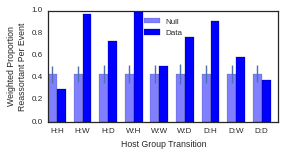

In [60]:
fig = plt.figure(figsize=(4,2))

ind = np.arange(len(means))
width = 0.35

ax = fig.add_subplot(1,1,1)
ax.bar(ind, means, width=width, color='blue', label='Null', yerr=np.array(stds)*5, alpha=0.5)
ax.bar(ind+width, data, width=width, color='blue', label='Data')
ax.set_xticks(ind+width)
ax.set_xticklabels(names)
ax.set_ylabel('Weighted Proportion\nReassortant Per Event')
ax.set_xlabel('Host Group Transition')
ax.legend(loc='upper center')
plt.subplots_adjust(left=0.15, right=0.95)
plt.savefig('figures/Proportion Reassortant Ecological.pdf')
plt.show()

In [61]:
np.array(means) - np.array(data)

array([ 0.13336787, -0.53276635, -0.29829818, -0.55688739, -0.07023384,
       -0.33128533, -0.47499022, -0.15213249,  0.05179162])